In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import numpy as np
import csv

import matplotlib.pyplot as plt

myseed = 69
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)
    print('cuda init succes')

cuda init succes


## **data process**

In [2]:
# path = './covid.train.csv'
# with open(path, 'r') as csv_file:
#     data = list(csv.reader(csv_file))
#     data = np.array(data[1:]) # 去除英文標籤
#     data = data[:,1:].astype(float) # 去除ID編號
# country = data[:,:40]
# print(country)

In [3]:
#1.每條训练样本由95列構成，含意如下:
# [0]： id，沒用信息，可删除
# [1,40]：所在州 one-hot表示
# [41,58]：2天前的特徵
# [59,76]：1天前的特徵
# [77,95]：當天特徵
def another_data_process(data):
    country = data[:,:40]
    day1 = list(range(40,58))
    day2 = list(range(58,76))
    day1_data = data[:, day1]
    new_data1 = np.concatenate((country, day1_data), axis = 1)
    day2_data = data[:, day2]
    new_data2 = np.concatenate((country, day2_data), axis = 1)
    final_data = np.concatenate((new_data1, new_data2), axis = 0)
    return final_data

def another_data_process_2(data):
    # 在訓練資料這邊
    country = data[:,:40]
    day1 = list(range(40,58))
    day2 = list(range(58,76))
    day3 = list(range(76,94))
    day1_data = data[:, day1]
    new_data1 = np.concatenate((country, day1_data), axis = 1)
    day2_data = data[:, day2]
    new_data2 = np.concatenate((country, day2_data), axis = 1)
    day3_data = data[:, day3]
    new_data3 = np.concatenate((country, day3_data), axis = 1)
    final_data = np.concatenate((new_data1, new_data2, new_data3), axis = 0)
#     print(final_data.shape)
    return final_data

In [4]:
class COVID19_data_process(Dataset):
    def __init__(self, path, mode):
        self.mode = mode
        
        with open(path, 'r') as csv_file:
            data = list(csv.reader(csv_file))
            data = np.array(data[1:]) # 去除英文標籤
            data = data[:,1:].astype(float) # 去除ID編號

        
        #1.每條训练样本由95列構成，含意如下:
        # [0]： id，沒用信息，可删除
        # [1,40]：所在州 one-hot表示
        # [41,58]：2天前的特徵
        # [59,76]：1天前的特徵
        # [77,95]：當天特徵
        
        if mode == 'test':
            country = data[:, :40]
            test_feature = data[:, 76:]
            new_testdata = np.concatenate((country, test_feature), axis = 1)
            # convert data to torch tensor
            self.data = torch.FloatTensor(new_testdata)
#         elif mode == 'test_have_ans':
#             data_preprocess = another_data_process(data)
#             final_data = data_preprocess[:,:-2]
#             target = data_preprocess[:,-1]
#             self.data = torch.FloatTensor(final_data)
#             self.target = torch.FloatTensor(target)
        else:

            data_preprocess = another_data_process_2(data)
            final_data = data_preprocess[:,:-1]
            target = data_preprocess[:,-1]
            if mode == 'train':
                indicates = [i for i in range(len(data_preprocess)) if i % 10 != 0]
            elif mode == 'vali': 
                indicates = [i for i in range(len(data_preprocess)) if i % 10 == 0]
                      
            self.data = torch.FloatTensor(final_data[indicates])
            self.target = torch.FloatTensor(target[indicates])
        ### 正規化 可槓掉看結果差異 (收斂不易)
        self.data[:,40:] = ((self.data[:,40:] - self.data[:,40:].mean(dim=0, keepdim=True)) /
                            self.data[:,40:].std(dim=0, keepdim=True))

        
        
        self.dim = self.data.shape[1]
        print(' Finish {:} read, it got all {:}, and shape is {:}'
              .format(mode, len(self.data), self.data.shape))
        
    def __getitem__(self, index):
        if self.mode in ['train', 'vali']:
            return self.data[index], self.target[index]
        else:
            # testing data 沒有 target 值，那是我們要預測的
            return self.data[index]
        
    def __len__(self):
        return len(self.data)
    

In [5]:
def pre_loader(path, mode, batch_size):
    ## 從 class 生成數據集在丟入 Dataloader
    dataset = COVID19_data_process(path, mode=mode)
    ## pin_memory 將資料先存入內存，這樣轉去 gpu 會較快
    dataloader = DataLoader(dataset, batch_size,
                           shuffle=(mode == 'train'), drop_last=False,
                           num_workers=0, pin_memory = True)
    return dataloader

## **Neural Network**

In [6]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,4),
            nn.ReLU(),
            nn.Linear(4,1),
            nn.ReLU(),
        )
        ## MSE
        self.criterion = nn.MSELoss(reduction = 'mean')
        
    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        # shape 180 x 1 != shape 180 的概念
        return self.net(x).squeeze(1)
    
    def call_loss(self, pred, target):
        return self.criterion(pred, target)
    

## Train / vali / test

In [7]:
# train
def training(train_dataset, vali_dataset, model, device):
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0005) 

    min_mse = 1000.
    loss_record = {'train': [], 'vali': []}
    early_stop_cnt = 0
    n_epochs = 3000
    epoch = 0
    while epoch < n_epochs:
        model.train()
        for data, label in train_dataset:
            optimizer.zero_grad()
            data, label = data.to(device), label.to(device)
            pred = model(data)
            mse_loss = model.call_loss(pred, label)
            mse_loss.backward() # compute gradient (backpropagation)
            optimizer.step() # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())
#             loss_record['train'].append(mse_loss.cpu().item())
        # After each epoch, test your model on the validation (development) set.
        vali_mse = validate(vali_dataset, model, device)
#         print(vali_mse)
        if vali_mse < min_mse:
            min_mse = vali_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                 .format(epoch+1, min_mse))
            torch.save(model.state_dict(), './HW1.pth')
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1        
    
        epoch += 1
        loss_record['vali'].append(vali_mse)
        if early_stop_cnt > 150:
            break
        
        if epoch % 100 == 0:
            # plot and show learning process
            plt.cla()
            plt.scatter(label.cpu().detach().numpy(), pred.cpu().detach().numpy())
            plt.plot(label.cpu().detach().numpy(), pred.cpu().detach().numpy(), 'r-', lw=2)
            plt.text(0.5, 0, 'Loss=%.4f' % min_mse, fontdict={'size': 20, 'color':  'red'})
#             plt.savefig('./img'+'%s'%epoch+'.jpg')
            plt.pause(0.1)
    print('Finish training {} epochs'.format(epoch))
    return min_mse, loss_record

In [8]:
# validation
def validate(vali_dataset, model, device):
    model.eval()
    total_loss = 0
    for data, label in vali_dataset:
        data, label = data.to(device), label.to(device)
        with  torch.no_grad(): # 評估驗算時，不需要更新參數
            pred = model(data)
            mse_loss = model.call_loss(pred, label) 
        total_loss += mse_loss.detach().cpu().item() * len(data)
#         total_loss += mse_loss.cpu().item() * len(data)
    total_loss = total_loss / len(vali_dataset.dataset)
    return total_loss

In [9]:
# test
def testing(test_dataset, model, device):
    model.eval()
    pred_label = []
    for data in test_dataset:
        data = data.to(device)
        with torch.no_grad():
            pred = model(data)
            pred_label.append(pred.detach().cpu())
#             pred_label.append(pred.cpu())
    pred_label = torch.cat(pred_label, dim=0).numpy() 
    return pred_label

In [10]:
def get_device():
    # 檢查是不是有 GPU 可以用，可以就用 GPU，不行就更改
    return 'cuda' if torch.cuda.is_available() else 'cpu'
device  = get_device()
print(device)

cuda


In [11]:
train_file_path = './covid.train.csv'
test_file_path = './covid.test.csv'

train_dataset = pre_loader(train_file_path, 'train', batch_size = 128)
# test_dataset = pre_loader(train_file_path, 'test_have_ans', batch_size = 128)
vali_dataset = pre_loader(train_file_path, 'vali', batch_size = 128)

need_pred_dataset = pre_loader(test_file_path, 'test',  batch_size = 128)

 Finish train read, it got all 7290, and shape is torch.Size([7290, 57])
 Finish vali read, it got all 810, and shape is torch.Size([810, 57])
 Finish test read, it got all 893, and shape is torch.Size([893, 57])


In [12]:
print(train_dataset.dataset.target)

tensor([20.1518, 20.7049, 21.2929,  ..., 12.6134, 12.4772, 11.8117])


In [13]:
model = NeuralNet(train_dataset.dataset.dim).to(device)

Saving model (epoch =    1, loss = 300.1880)
Saving model (epoch =    2, loss = 120.4699)
Saving model (epoch =    3, loss = 23.6226)
Saving model (epoch =    4, loss = 16.9081)
Saving model (epoch =    5, loss = 13.0824)
Saving model (epoch =    6, loss = 10.3657)
Saving model (epoch =    7, loss = 8.3799)
Saving model (epoch =    8, loss = 6.8940)
Saving model (epoch =    9, loss = 5.8541)
Saving model (epoch =   10, loss = 5.0831)
Saving model (epoch =   11, loss = 4.5531)
Saving model (epoch =   12, loss = 4.1892)
Saving model (epoch =   13, loss = 3.9245)
Saving model (epoch =   14, loss = 3.6934)
Saving model (epoch =   15, loss = 3.5106)
Saving model (epoch =   16, loss = 3.3814)
Saving model (epoch =   17, loss = 3.2737)
Saving model (epoch =   18, loss = 3.1551)
Saving model (epoch =   19, loss = 3.0653)
Saving model (epoch =   20, loss = 3.0109)
Saving model (epoch =   21, loss = 2.9367)
Saving model (epoch =   22, loss = 2.8990)
Saving model (epoch =   23, loss = 2.7931)
Sav

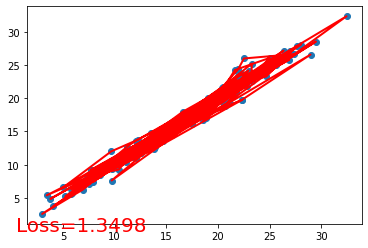

Saving model (epoch =  102, loss = 1.3471)
Saving model (epoch =  105, loss = 1.2934)
Saving model (epoch =  109, loss = 1.2768)
Saving model (epoch =  110, loss = 1.2748)
Saving model (epoch =  112, loss = 1.2325)
Saving model (epoch =  116, loss = 1.2306)
Saving model (epoch =  117, loss = 1.1984)
Saving model (epoch =  119, loss = 1.1809)
Saving model (epoch =  121, loss = 1.1750)
Saving model (epoch =  122, loss = 1.1646)
Saving model (epoch =  124, loss = 1.1434)
Saving model (epoch =  128, loss = 1.1274)
Saving model (epoch =  130, loss = 1.1039)
Saving model (epoch =  133, loss = 1.0878)
Saving model (epoch =  138, loss = 1.0718)
Saving model (epoch =  139, loss = 1.0496)
Saving model (epoch =  140, loss = 1.0192)
Saving model (epoch =  144, loss = 1.0177)
Saving model (epoch =  145, loss = 1.0173)
Saving model (epoch =  146, loss = 1.0171)
Saving model (epoch =  147, loss = 0.9966)
Saving model (epoch =  150, loss = 0.9750)
Saving model (epoch =  151, loss = 0.9693)
Saving mode

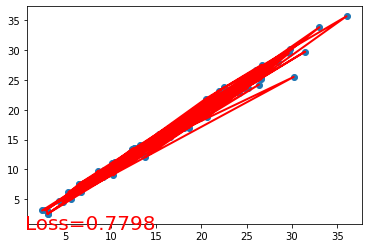

Saving model (epoch =  203, loss = 0.7646)
Saving model (epoch =  206, loss = 0.7626)
Saving model (epoch =  208, loss = 0.7585)
Saving model (epoch =  210, loss = 0.7372)
Saving model (epoch =  223, loss = 0.7155)
Saving model (epoch =  225, loss = 0.6992)
Saving model (epoch =  229, loss = 0.6981)
Saving model (epoch =  230, loss = 0.6869)
Saving model (epoch =  238, loss = 0.6777)
Saving model (epoch =  244, loss = 0.6748)
Saving model (epoch =  248, loss = 0.6665)
Saving model (epoch =  249, loss = 0.6602)
Saving model (epoch =  252, loss = 0.6514)
Saving model (epoch =  255, loss = 0.6504)
Saving model (epoch =  261, loss = 0.6456)
Saving model (epoch =  263, loss = 0.6340)
Saving model (epoch =  267, loss = 0.6200)
Saving model (epoch =  271, loss = 0.6118)
Saving model (epoch =  278, loss = 0.6033)
Saving model (epoch =  289, loss = 0.5955)
Saving model (epoch =  291, loss = 0.5939)
Saving model (epoch =  296, loss = 0.5808)
Saving model (epoch =  298, loss = 0.5798)


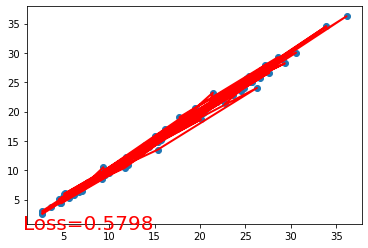

Saving model (epoch =  304, loss = 0.5740)
Saving model (epoch =  308, loss = 0.5689)
Saving model (epoch =  317, loss = 0.5604)
Saving model (epoch =  320, loss = 0.5578)
Saving model (epoch =  333, loss = 0.5505)
Saving model (epoch =  338, loss = 0.5363)
Saving model (epoch =  343, loss = 0.5294)
Saving model (epoch =  365, loss = 0.5213)
Saving model (epoch =  371, loss = 0.5182)
Saving model (epoch =  373, loss = 0.5117)
Saving model (epoch =  387, loss = 0.5081)
Saving model (epoch =  391, loss = 0.5029)
Saving model (epoch =  394, loss = 0.4995)
Saving model (epoch =  399, loss = 0.4872)


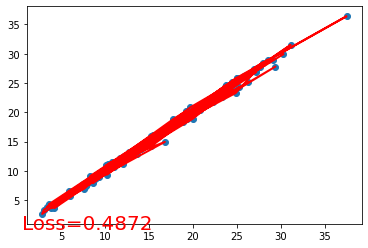

Saving model (epoch =  412, loss = 0.4825)
Saving model (epoch =  419, loss = 0.4801)
Saving model (epoch =  424, loss = 0.4655)
Saving model (epoch =  450, loss = 0.4641)
Saving model (epoch =  464, loss = 0.4554)
Saving model (epoch =  467, loss = 0.4546)
Saving model (epoch =  470, loss = 0.4447)
Saving model (epoch =  478, loss = 0.4425)
Saving model (epoch =  493, loss = 0.4268)
Saving model (epoch =  497, loss = 0.4197)


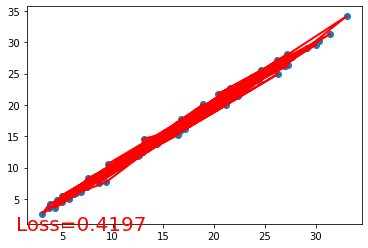

Saving model (epoch =  528, loss = 0.4147)
Saving model (epoch =  548, loss = 0.4110)
Saving model (epoch =  549, loss = 0.4109)
Saving model (epoch =  554, loss = 0.4022)
Saving model (epoch =  558, loss = 0.3978)
Saving model (epoch =  586, loss = 0.3920)


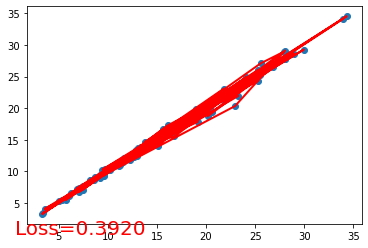

Saving model (epoch =  606, loss = 0.3851)
Saving model (epoch =  614, loss = 0.3850)
Saving model (epoch =  616, loss = 0.3765)
Saving model (epoch =  618, loss = 0.3739)
Saving model (epoch =  627, loss = 0.3722)
Saving model (epoch =  643, loss = 0.3650)
Saving model (epoch =  666, loss = 0.3643)
Saving model (epoch =  680, loss = 0.3496)
Saving model (epoch =  699, loss = 0.3482)
Saving model (epoch =  700, loss = 0.3457)


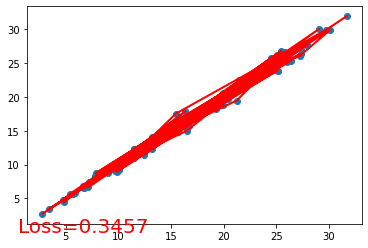

Saving model (epoch =  722, loss = 0.3448)
Saving model (epoch =  737, loss = 0.3415)
Saving model (epoch =  743, loss = 0.3407)
Saving model (epoch =  753, loss = 0.3233)
Saving model (epoch =  781, loss = 0.3175)


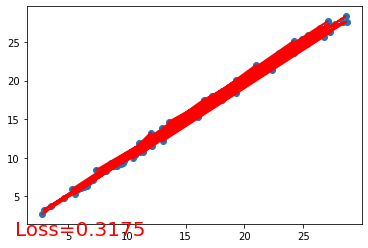

Saving model (epoch =  837, loss = 0.3154)
Saving model (epoch =  863, loss = 0.3048)
Saving model (epoch =  875, loss = 0.3029)
Saving model (epoch =  897, loss = 0.3017)


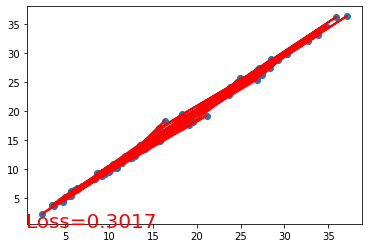

Saving model (epoch =  904, loss = 0.3015)
Saving model (epoch =  913, loss = 0.3008)
Saving model (epoch =  922, loss = 0.2970)
Saving model (epoch =  925, loss = 0.2963)
Saving model (epoch =  940, loss = 0.2939)
Saving model (epoch =  957, loss = 0.2906)
Saving model (epoch =  971, loss = 0.2874)
Saving model (epoch = 1000, loss = 0.2855)


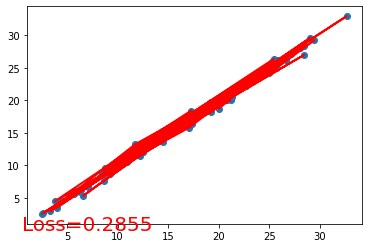

Saving model (epoch = 1022, loss = 0.2813)
Saving model (epoch = 1059, loss = 0.2792)
Saving model (epoch = 1062, loss = 0.2753)
Saving model (epoch = 1070, loss = 0.2698)


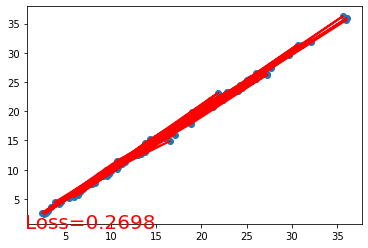

Saving model (epoch = 1132, loss = 0.2684)
Saving model (epoch = 1148, loss = 0.2682)
Saving model (epoch = 1160, loss = 0.2644)
Saving model (epoch = 1176, loss = 0.2617)


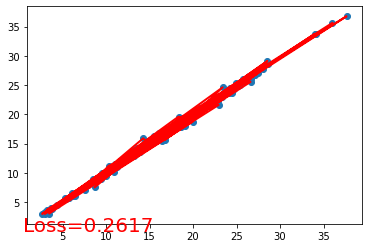

Saving model (epoch = 1226, loss = 0.2565)
Saving model (epoch = 1227, loss = 0.2551)
Saving model (epoch = 1265, loss = 0.2549)
Saving model (epoch = 1280, loss = 0.2507)
Saving model (epoch = 1295, loss = 0.2502)


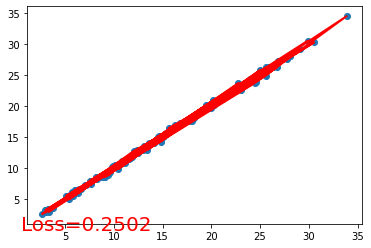

Saving model (epoch = 1310, loss = 0.2492)
Saving model (epoch = 1324, loss = 0.2441)
Saving model (epoch = 1384, loss = 0.2436)
Saving model (epoch = 1395, loss = 0.2397)


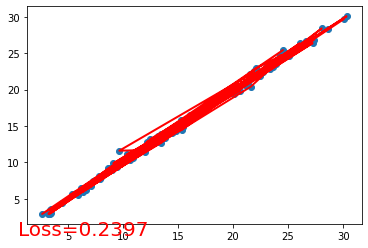

Saving model (epoch = 1439, loss = 0.2390)
Saving model (epoch = 1481, loss = 0.2369)


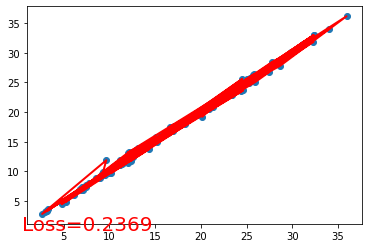

Saving model (epoch = 1503, loss = 0.2347)
Saving model (epoch = 1522, loss = 0.2308)
Saving model (epoch = 1547, loss = 0.2305)
Saving model (epoch = 1588, loss = 0.2285)


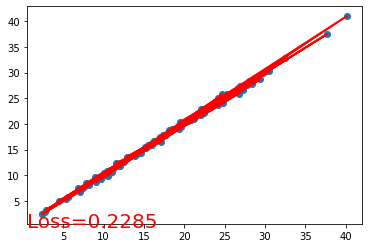

Saving model (epoch = 1615, loss = 0.2266)
Saving model (epoch = 1617, loss = 0.2226)
Saving model (epoch = 1675, loss = 0.2215)


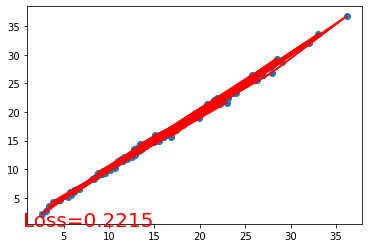

Saving model (epoch = 1702, loss = 0.2204)
Saving model (epoch = 1770, loss = 0.2136)
Saving model (epoch = 1800, loss = 0.2128)


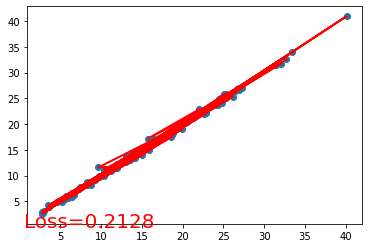

Saving model (epoch = 1832, loss = 0.2116)
Saving model (epoch = 1861, loss = 0.2050)


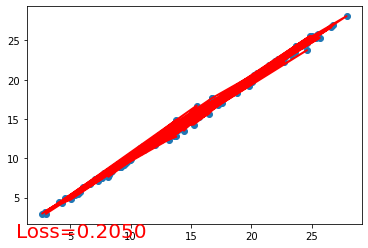

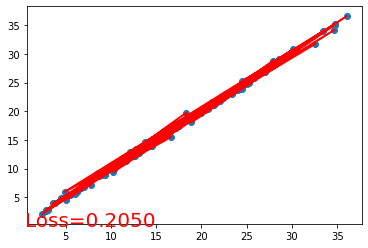

Saving model (epoch = 2006, loss = 0.2023)
Saving model (epoch = 2088, loss = 0.2021)


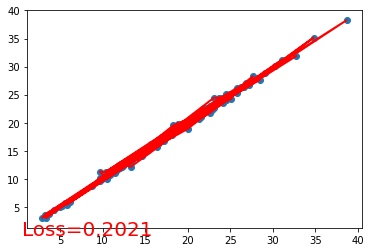

Saving model (epoch = 2116, loss = 0.2008)
Saving model (epoch = 2150, loss = 0.1952)


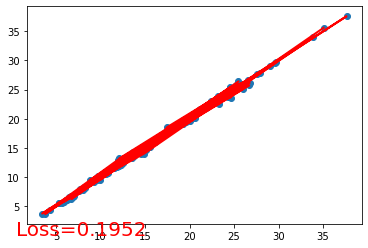

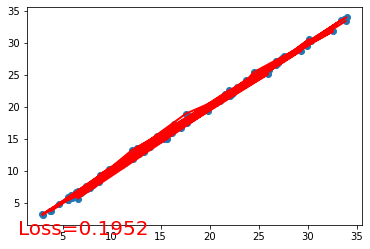

Finish training 2301 epochs


In [14]:
model_loss, model_record_loss = training(train_dataset, vali_dataset, model, device)

In [15]:
def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & vali loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
#     print(x_1)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['vali'])]
    plt.figure(figsize=(12, 10))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['vali'], c='tab:cyan', label='vali')
    plt.ylim(0.0, 2.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(vali_dataset, model, device, lim=10., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in vali_dataset:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()
#     print(preds)
#     print(targets)
    plt.figure(figsize=(12, 12))
    plt.scatter(targets, preds, c='r')
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

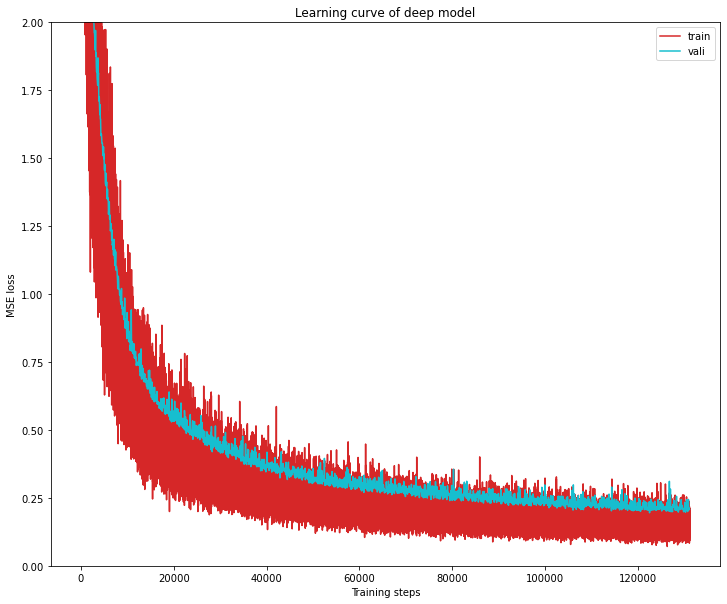

In [16]:
plot_learning_curve(model_record_loss, title='deep model')

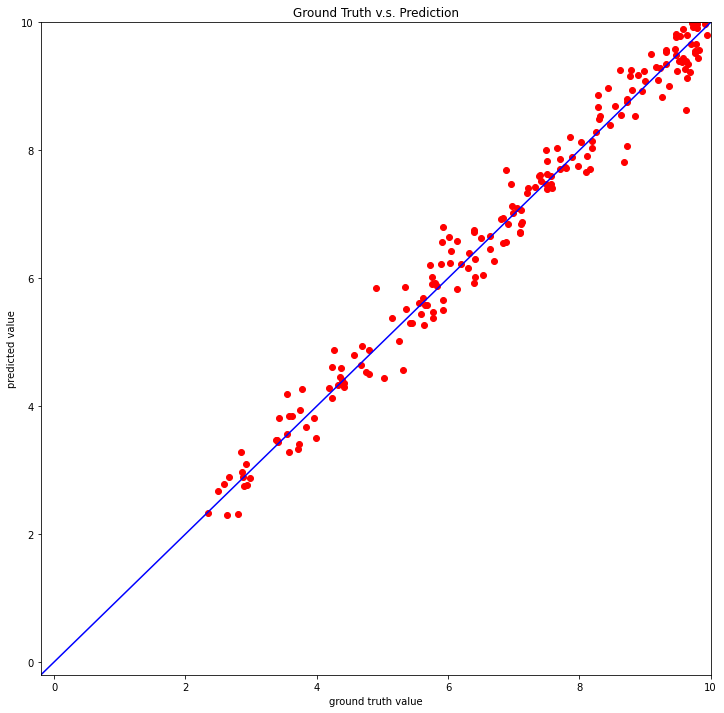

In [17]:
del model
model = NeuralNet(train_dataset.dataset.dim).to(device)
ckpt = torch.load('./HW1.pth', map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(vali_dataset, model, device)  # Show prediction on the validation set

In [18]:
# save 
file = 'pred4.csv'
test_pred = testing(need_pred_dataset, model, device)
print('prepare to save')
with open(file, 'w', newline='') as fp:
    writer = csv.writer(fp)
    writer.writerow(['id', 'tested_positive'])
    for index, content in enumerate(test_pred):
        writer.writerow([index, content])
print('end')

prepare to save
end


In [19]:
print(test_pred)

[24.483915  16.903412  16.68125    8.606905   9.972539  34.68747
 23.597971  16.490355  13.338054   7.3603625 13.185188  20.112791
 23.231821   7.3898206 21.34455   16.962217  28.104403  11.355485
 24.53697    9.726853   9.130174  22.9443    14.113084   7.154941
 17.820211  22.46929   28.414648  22.702929   3.9475017 18.834005
  3.4573092 21.726019  26.942934  17.013887  16.006655  41.53884
 14.669236  21.711823  23.23535    9.674365  22.935616   6.9597955
 11.569827  27.590288  20.22208   25.727575  13.257718   6.006262
  8.064896  23.23936   17.21472   27.172285  11.824166  11.7185
 15.810119  32.317528   8.812358  14.842528  31.089966  12.134927
 20.430862  27.945295  33.99098   21.075296  16.436544   8.850313
 25.354317  22.216898  39.714798  26.986792  26.275331  34.664337
 15.910546  30.504099  12.596267  12.042237  22.403898  19.108934
  3.646522  11.719193  13.775194  10.283123  12.588013  18.942076
  4.1720967 24.874683  23.773401   2.598421   5.3746247 15.486705
 29.247759  2